# Predicting Hotel Cancellations

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

March 2022




## Initial Setup

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import statsmodels as sm
from math import ceil
import os

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

import graphviz

import warnings
warnings.filterwarnings('ignore')

from matplotlib.colors import LinearSegmentedColormap

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, f_regression


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import f1_score

from sklearn.neural_network import MLPClassifier

from sklearn.impute import KNNImputer

In [3]:
## Note versions used

print('Pandas version ',pd.__version__)
print('Numpy version ',np.__version__)
print('Scipy version ',sp.__version__)
print('Seaborn version ',sns.__version__)


Pandas version  1.3.3
Numpy version  1.20.3
Scipy version  1.7.0
Seaborn version  0.11.2


In [4]:
COLORS = ['#22446d', '#446f8b', '#689ea6', '#94cdbc', '#e6f9af', '#f5b68e', '#eb756f', '#cb3553', '#93003a']

CAT_COLORS = ['#22446D', '#6ABB5D', '#F3E97B', '#FC9E4F', '#AB2346']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = COLORS.copy()

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
CAT_PALETTE = sns.color_palette(CAT_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = False
RANDOM_STATE = 0

show_plots = True
img_counter = 0
random_state = 0

IMG_PATH = 'imgs/'
DATA_PATH = 'data/'


In [5]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 70

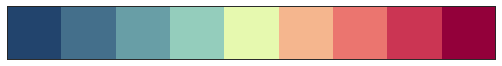

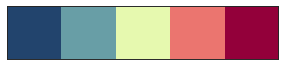

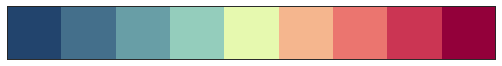

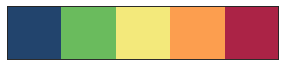

In [6]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Define some helper functions

In [7]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight')
        


In [8]:
## Function to plot histograms of numeric features for specified dataframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if SHOW_PLOTS:
        cols = ceil(len(features) / rows)
        fig = plt.figure(figsize=(4*cols,4*rows),
                         constrained_layout=True)
        
        subfigs = fig.subfigures(rows, cols)
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(2, 1, sharex=True, \
                                gridspec_kw={'height_ratios': [4,1]})
        
            axs[0].hist(df[feat], color=COLORS[0])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1, fontsize=6*rows)
        
            axs[1].set_xlabel(None)
            flierprops = dict(markerfacecolor='None', markersize=6,  markeredgecolor=COLORS[0])
            sns.boxplot(x=df[feat], ax=axs[1], color=COLORS[0], flierprops=flierprops)
            axs[1].set_xlabel(None)

            subf.suptitle(None)
        
        plt.suptitle(title, fontsize=8*rows)
        if SAVE_PLOTS:
            save_fig(title, fig)
        
        plt.show()
    else:
        print("show_plots is currently set to False")

In [9]:
def getIQR(df, colname) :
    q25 = df[colname].quantile(.25)
    q75 = df[colname].quantile(.75)
    iqr = (q75 - q25)

    upper_lim = q75 + 2 * iqr
    lower_lim = q25 - 2 * iqr

    above_ul = df.loc[df[colname]>upper_lim]
    below_ll = df.loc[df[colname]<lower_lim]
    
    if len(above_ul) > 0 :
        print(str(len(above_ul)) + " or " + str(round((100*len(above_ul)/len(df)),4)) + "% of rows are above the UL ["+ colname + "].")
    if len(below_ll) > 0 :
        print(str(len(below_ll)) + " or " + str(round((100*len(below_ll)/len(df)),4)) + "% of rows are below the LL ["+ colname + "].")

    
    return upper_lim, lower_lim, len(above_ul), len(below_ll)




In [10]:
df = pd.read_csv('../../source/H2.csv')

## Remove last row
#df.drop(df.tail(1).index,inplace=True)
#df['Custid'] = df['Custid'].astype(int)
#df.set_index('Custid', inplace=True)

df_original = df.copy(deep=True)

df.head(3)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30


## Data Preprocessing

### Convert types

In [11]:
MONTHS = ['January', 'February', 'March', 'April', 'May','June',
          'July','August','September','October','November','December']

MONTH_NUMS = [i+1 for i in range(12)]

df['ArrivalDateMonthNumber'] = df['ArrivalDateMonth'].replace(to_replace=MONTHS, value=MONTH_NUMS)
df.loc[:,['ArrivalDateMonth','ArrivalDateMonthNumber']]

,ArrivalDateMonth,ArrivalDateMonthNumber
0,July,7
1,July,7
2,July,7
3,July,7
4,July,7
...,...,...
79325,August,8
79326,August,8
79327,August,8
79328,August,8


In [12]:
df['ArrivalDate'] = df['ArrivalDateYear'].astype(str) + '-' + df['ArrivalDateMonthNumber'].astype(str) + '-' + df['ArrivalDateDayOfMonth'].astype(str)
df['ArrivalDate'] = pd.to_datetime(df['ArrivalDate'])
# df['ArrivalDate']

In [13]:
df['ReservationStatusDate'] = pd.to_datetime(df['ReservationStatusDate'])
# print(df.dtypes)


### Check nulls

In [14]:
df['Company'] = df['Company'].replace('       NULL', np.nan)

In [15]:
df['Company'][0]

nan

In [16]:
df.isna().sum()

IsCanceled                         0
LeadTime                           0
ArrivalDateYear                    0
ArrivalDateMonth                   0
ArrivalDateWeekNumber              0
ArrivalDateDayOfMonth              0
StaysInWeekendNights               0
StaysInWeekNights                  0
Adults                             0
Children                           4
Babies                             0
Meal                               0
Country                           24
MarketSegment                      0
DistributionChannel                0
IsRepeatedGuest                    0
PreviousCancellations              0
PreviousBookingsNotCanceled        0
ReservedRoomType                   0
AssignedRoomType                   0
BookingChanges                     0
DepositType                        0
Agent                              0
Company                        75641
DaysInWaitingList                  0
CustomerType                       0
ADR                                0
R

Drop Company because too many nulls

In [17]:
df.drop(columns=['Company'],inplace=True)

### Check duplicates

In [18]:
## duplicates kept
df_hasdups = df.copy()

## duplicated rows
df_dups = df[df.duplicated(keep=False)]

## duplicates removed
df.drop_duplicates(keep='first', inplace=True)

### Separate numeric and non-numeric features

In [19]:
num_feats = df.select_dtypes(include=[np.number]).columns.tolist()
num_feats

['IsCanceled',
 'LeadTime',
 'ArrivalDateYear',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'Adults',
 'Children',
 'Babies',
 'IsRepeatedGuest',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'BookingChanges',
 'DaysInWaitingList',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'ArrivalDateMonthNumber']

In [20]:
cat_feats = df.columns.drop(num_feats).to_list()
cat_feats

['ArrivalDateMonth',
 'Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'ReservedRoomType',
 'AssignedRoomType',
 'DepositType',
 'Agent',
 'CustomerType',
 'ReservationStatus',
 'ReservationStatusDate',
 'ArrivalDate']

In [21]:
num_feats.remove('IsCanceled')
num_feats

['LeadTime',
 'ArrivalDateYear',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'Adults',
 'Children',
 'Babies',
 'IsRepeatedGuest',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'BookingChanges',
 'DaysInWaitingList',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'ArrivalDateMonthNumber']

## Feature Engineering

### Add regions for countries

In [22]:
## Data from https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv



In [23]:
country_info = pd.read_csv('../data_in/country_info.csv')
country_info.head(3)


,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN


In [24]:
# country_info.isna().sum()
# Drop nan region: Antarctica is not in dataset

In [25]:
country_info = country_info.loc[~country_info['region'].isna(),:]

In [26]:
df = pd.merge(df,country_info[['alpha-3','region','sub-region']],
              left_on='Country', right_on='alpha-3',
              how='left').drop(columns=['alpha-3'])

In [27]:
cat_feats.append('region')
cat_feats.append('sub-region')

### Add Season column

In [28]:
## From https://stackoverflow.com/questions/16139306/determine-season-given-timestamp-in-python-using-datetime

def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'


In [29]:
df['Season'] = df['ArrivalDate'].map(season_of_date)

In [30]:
df.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'DaysInWaitingList',
       'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'ArrivalDateMonthNumber', 'ArrivalDate', 'region', 'sub-region',
       'Season'],
      dtype='object')

In [31]:
cat_feats.append('Season')

## Inspect variables: Check histograms

In [47]:
#plot_histograms_boxplots(df, num_feats, rows=3)

In [48]:
#plot_histograms_boxplots(df_hasdups, num_feats, rows=3, title="Histograms with Duplicates Preserved")

In [34]:
## Function to plot histograms of numeric features for specified dataframe, divided by target variable
def plot_histograms_boxplots_target(df, features, target, rows=4, title = "Histograms of Numeric Variables with Target"):
    if show_plots:
        fig = plt.figure(figsize=(2.85*rows, 4*rows), constrained_layout=True)
        subfigs = fig.subfigures(rows, ceil(len(features) / rows))
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1,1]})
        
            df.pivot(columns=target)[feat].plot(kind = 'hist', stacked=True, ax=axs[0], color=CAT_COLORS[0:2])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1)
        
            sns.boxplot(x=df.loc[df[target]==0,feat], ax=axs[1], color=CAT_COLORS[0], fliersize=2)
            axs[1].set_xlabel(None)
        
            sns.boxplot(x=df.loc[df[target]==1,feat], ax=axs[2], color=CAT_COLORS[1], fliersize=2)
            axs[2].set_xlabel(None)
        
            subf.suptitle(None)

        plt.suptitle(title)
        plt.show()
        if SAVE_PLOTS:
            save_fig(title, fig)

    else:
        print("show_plots is currently set to False")

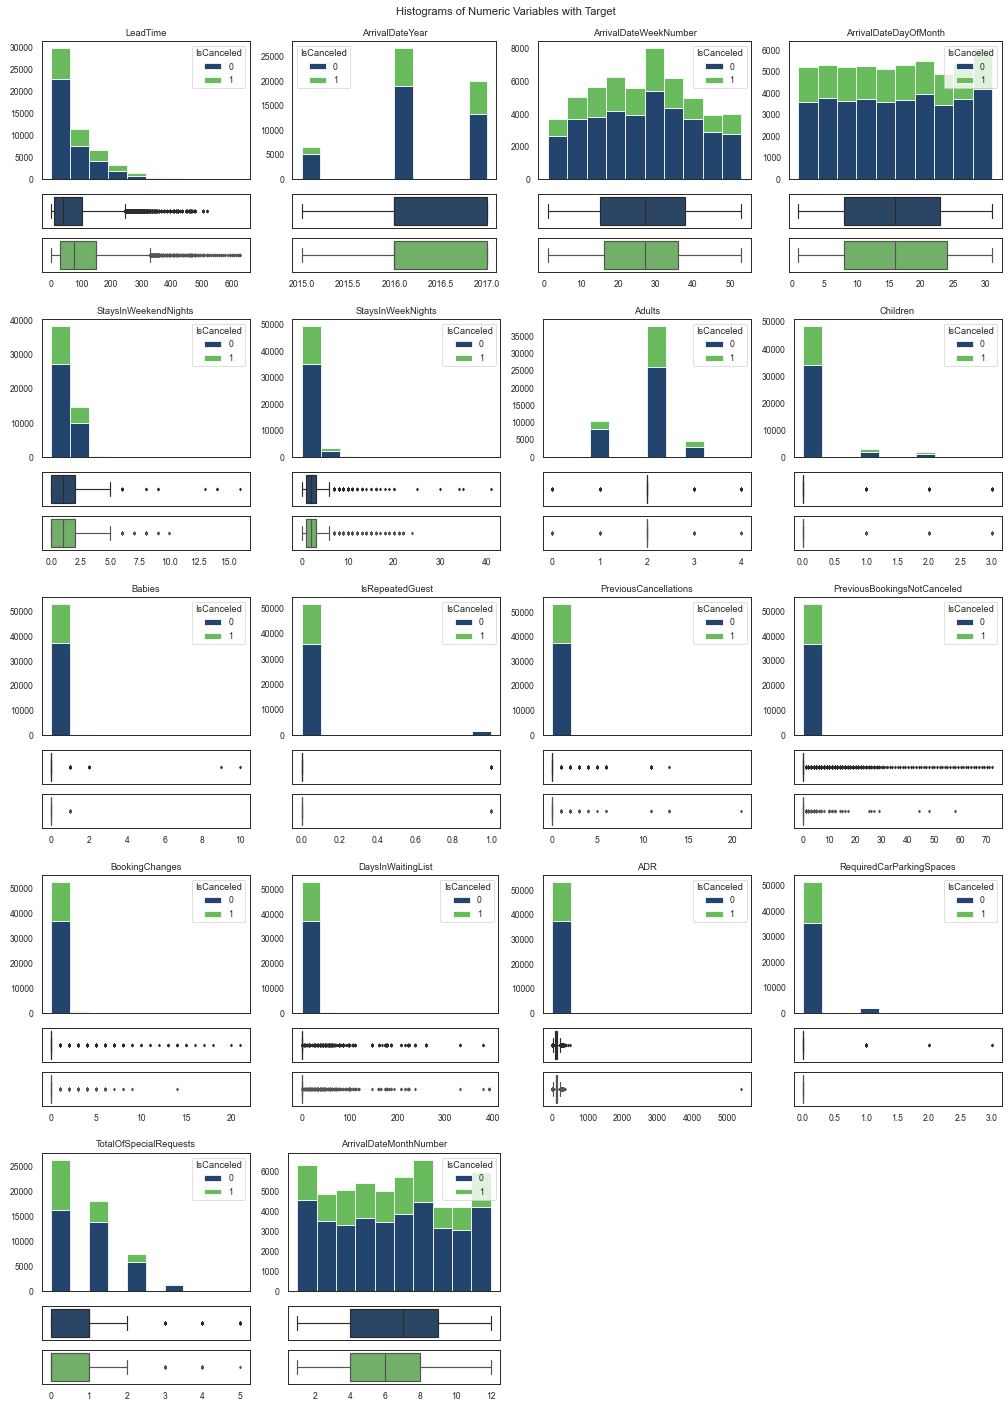

In [35]:
plot_histograms_boxplots_target(df, num_feats, 'IsCanceled', rows=5)

In [36]:
#plot_histograms_boxplots_target(df_hasdups, num_feats, 'IsCanceled', rows=5)

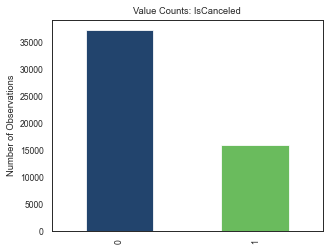

In [37]:
fig, ax = plt.subplots(figsize=(5,4))
df.groupby(['IsCanceled']).size()\
        .plot(kind="bar", stacked=False, color=CAT_COLORS[0:2])
ax.set_xlabel(None)
ax.set_ylabel('Number of Observations')
ax.set_title('Value Counts: IsCanceled')
plt.show()

In [38]:
## Function to plot histograms of cat features for specified dataframe
def plot_cat_counts(df, features, target, rows=6, title = "Count Distributions of Categorical Variables"):
    if show_plots:
        fig = plt.figure(figsize=(2.85*rows, 4*rows), constrained_layout=True)
        subfigs = fig.subfigures(rows, ceil(len(features) / rows), wspace=0.07, hspace=0.1)
        c = CAT_COLORS[0:2]
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(1, 2, sharey=True) #, gridspec_kw={'width_ratios': [4, 1,1]})
 
            df1 = df.groupby([feat,target]).size().unstack(1)\
                .plot(kind="barh", stacked=True, ax=axs[0], color=c)

            df2 = df.groupby([feat,target]).size().unstack(1)
            df2.div(df2.sum(axis=1), axis=0)\
                .plot(kind="barh", stacked=True, ax=axs[1], color=c)
            
            subf.suptitle(feat)
            

        plt.suptitle(title)
        plt.show()
        if SAVE_PLOTS:
            save_fig(title, fig)

    else:
        print("show_plots is currently set to False")

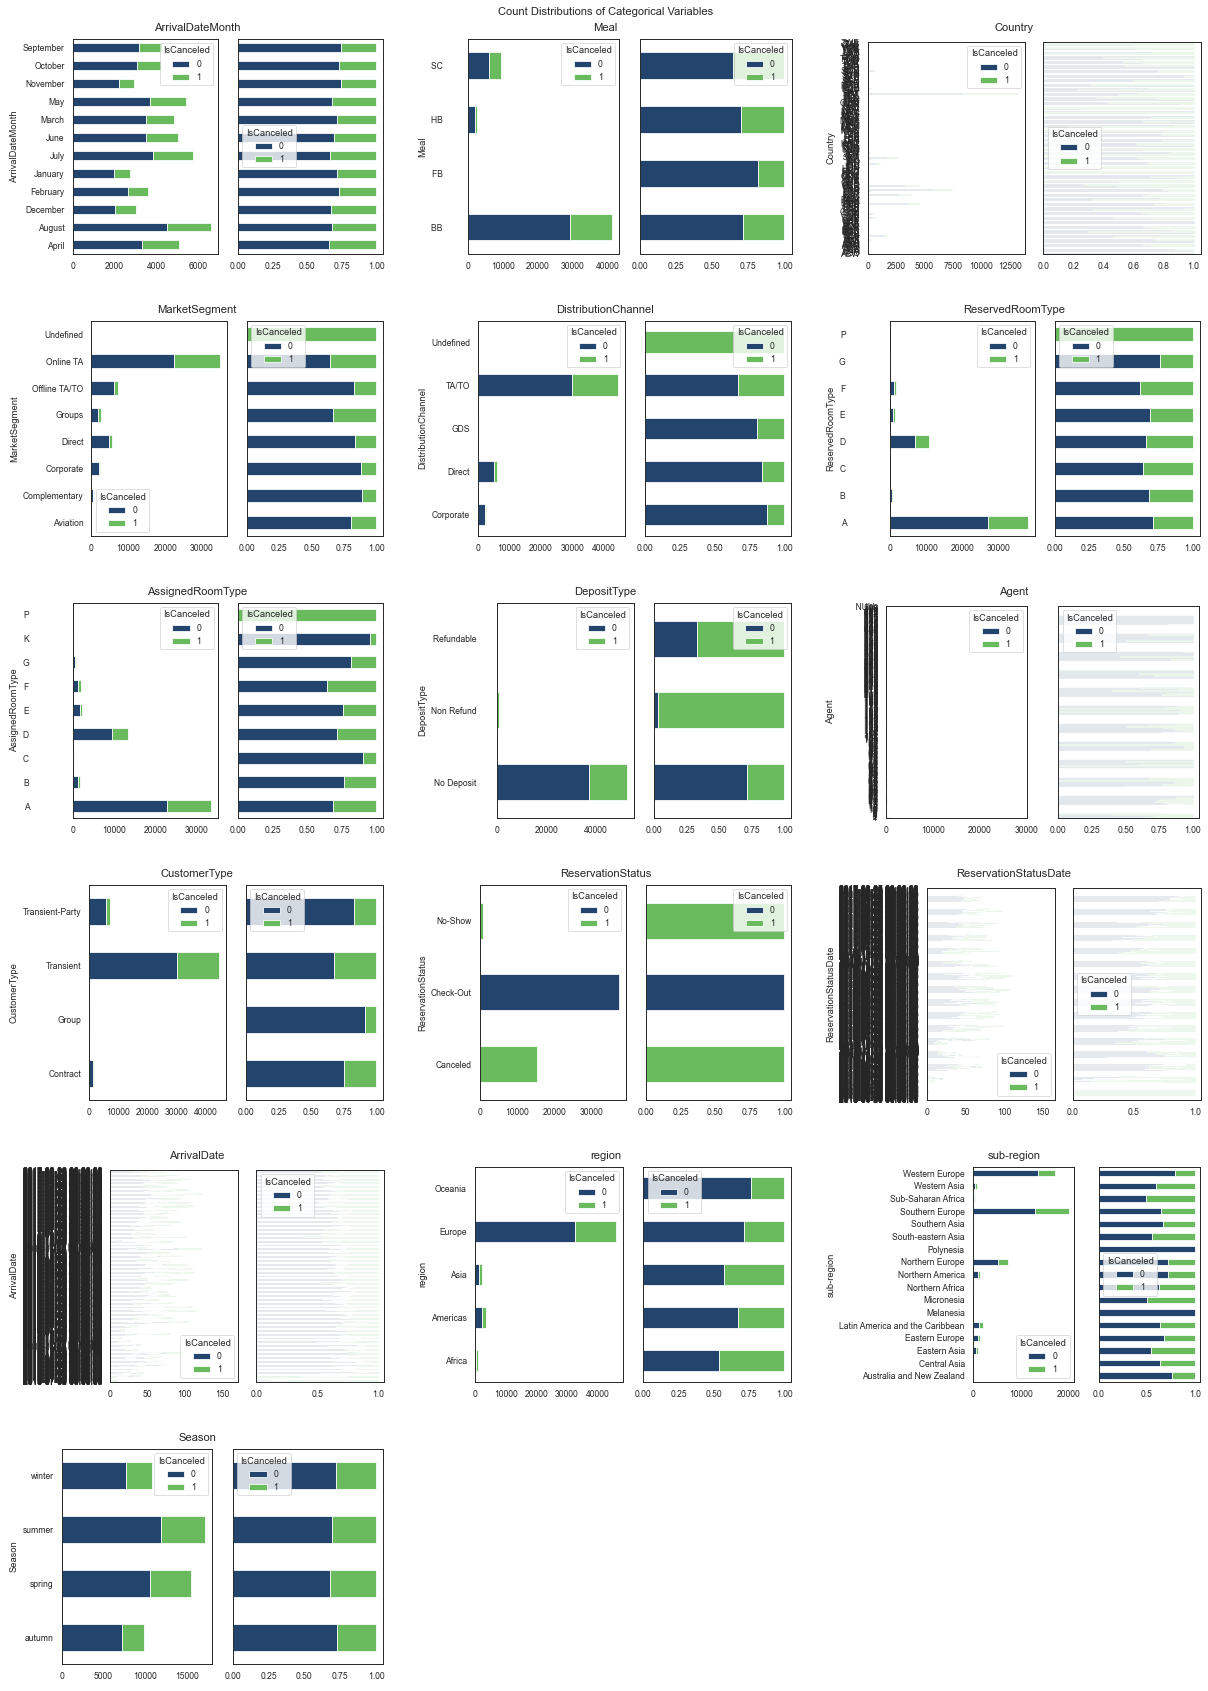

In [39]:
plot_cat_counts(df, cat_feats, 'IsCanceled', rows = 6)

In [40]:
# plot_cat_counts(df_hasdups, cat_feats, 'IsCanceled', rows = 6)

In [41]:
# aggregated and shape data

def show_barplot_compare(df, g1, g2) :
    if show_plots:
        
        df = df.sort_values(by=g2,ascending=False)
    
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(23,23))
 
        df1 = df.groupby([g1,g2]).size().unstack(1)\
                .plot(kind="barh", stacked=True, ax=ax[0], color=CONTRAST_COLORS)

        # aggregated and shape data
        df2 = df.groupby([g1,g2]).size().unstack(1)
        df2.div(df2.sum(axis=1), axis=0)\
                .plot(kind="barh", stacked=True, ax=ax[1], color=CONTRAST_COLORS)
    
        plt.show()
        if SAVE_PLOTS:
            save_fig('Bar plot '+ g1 + ' ' + g2, fig)
            

In [42]:
def absolute_relative_histoplot(df, feat, target, title='Absolute and Relative Distributions of Canceled Status by Country', figsize=(21,28)):
    df_ar = df.groupby([feat,target]).size().unstack()
    df_ar = df_ar.T.reset_index(drop=True).T.replace(np.nan,0)
    df_ar['total'] = df_ar[0]+df_ar[1]
    df_ar.sort_values(by='total', inplace=True)


    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True)
    df_ar[target] = df_ar[1]
    not_t = 'Not ' + target
    df_ar[not_t] = df_ar[0]

    df_ar.loc[:,[not_t, target]]\
                     .plot(kind="barh", width=1, stacked=True, ax=ax[1], color=CAT_COLORS)
    ax[1].legend(bbox_to_anchor=(.6,1,.4,1), loc="lower left", frameon=False,
                            mode='expand', borderaxespad=0, ncol=2)
    ax[1].set_title('Absolute Distribution', loc='left', fontsize=18)


    df_cc2 = df_ar.loc[:,[not_t, target]].div(df_ar['total'], axis=0)\
                    .plot(kind="barh", width=1, stacked=True, ax=ax[0], color=CAT_COLORS)
    ax[0].legend(bbox_to_anchor=(.6,1,.4,1), loc="lower left", frameon=False,
                            mode='expand', borderaxespad=0, ncol=2)
    ax[0].set_title('Relative Distribution', loc='left', fontsize=18)

    
    ax[0].yaxis.set_label_position("right")
    ax[0].yaxis.tick_right()
    ax[0].set_ylabel(None)
    ax[1].set_ylabel(None)

    
    fig.suptitle(title, fontsize=24)
    plt.tight_layout()
    plt.show()
    

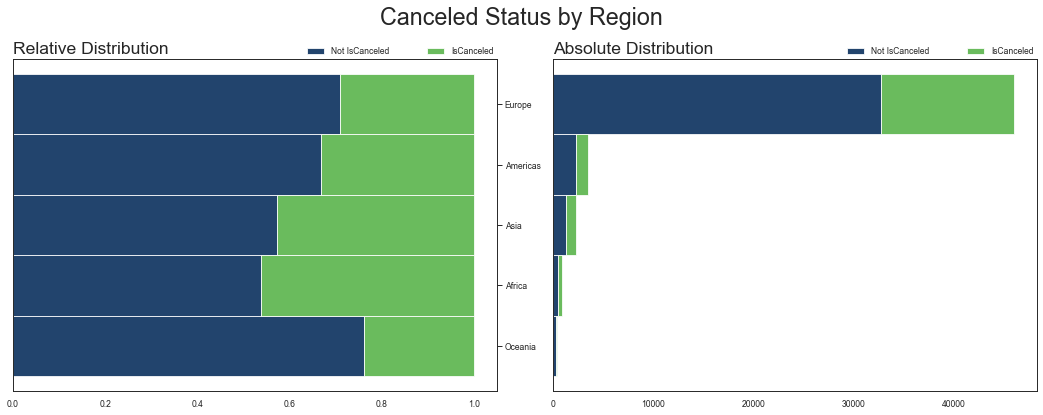

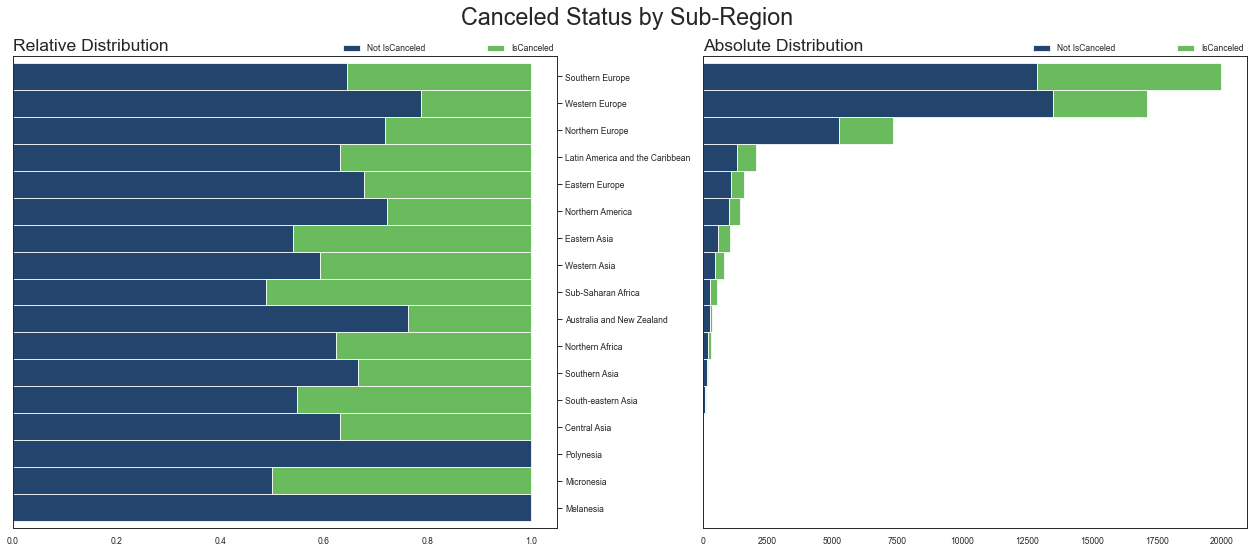

In [43]:
absolute_relative_histoplot(df, 'region', 'IsCanceled', title='Canceled Status by Region', figsize=(15,6))
absolute_relative_histoplot(df, 'sub-region', 'IsCanceled', title='Canceled Status by Sub-Region', figsize=(18,8))


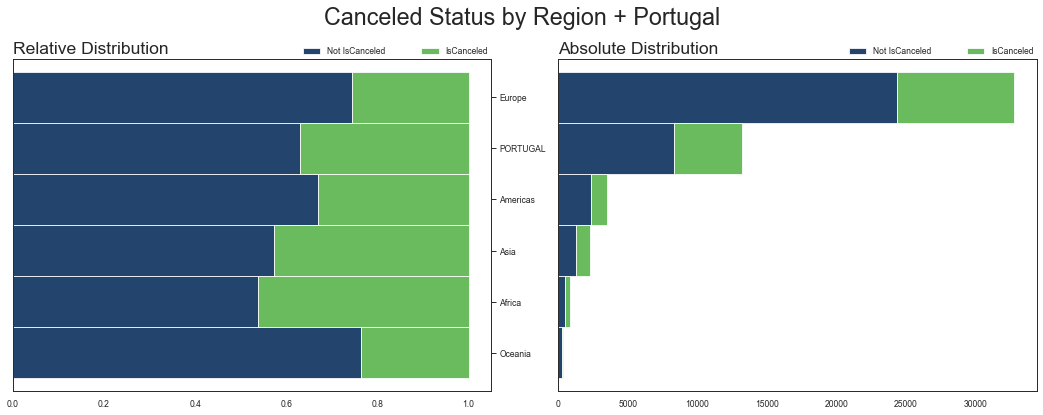

In [49]:
df['region alt'] = df['region']
df.loc[df['Country']=='PRT',['region alt']] = 'PORTUGAL'
absolute_relative_histoplot(df, 'region alt', 'IsCanceled', title='Canceled Status by Region + Portugal', figsize=(15,6))


## Repeated Stratified K Fold

In [45]:
def avg_score(model, data_to_slice, y_to_slice, columns_to_use):
    # apply kfold
    skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    f1_list = []

    for train_index, test_index in skf.split(data_to_slice[columns_to_use],y_to_slice):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = data_to_slice[columns_to_use].iloc[train_index], data_to_slice[columns_to_use].iloc[test_index]
        y_train, y_val = y_to_slice.iloc[train_index], y.iloc[test_index]
        
        # applies the model 
        model_fit = model.fit(X_train, y_train)
        # predicts training 
        y_pred_train =  model_fit.predict(X_train)
        #predicts validation 
        y_pred_val = model_fit.predict(X_val)
        # prints metric results 
        
        #metrics(X_train, X_val, y_train, y_pred_train, y_val, y_pred_val, model)
        
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_val,y_val)
        f1_score_val = f1_score(y_val, y_pred_val)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        f1_list.append(f1_score_val)
        
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    avg_f1 = round(np.mean(f1_list),3)
    std_f1 = round(np.std(f1_list),2)
    return str(avg_train) + '+/-' + str(std_train),\
            str(avg_test) + '+/-' + str(std_test) , str(avg_f1) + '+/-' + str(std_f1), avg_f1

## Apply Scaling

In [46]:
def scale_join (scale, features,X_train, X_val, test):
    '''Scale(string): Type of scale. If 'minmax' = MinMaxScaler(), if 'minmax2' = MinMaxScaler(feature_range=(-1,1))
    if 'robust' = RobustScaler(), if 'standard = StandardScaler()'
    features(list): features to use on our data set. If you have 2 or more lists use the + sign
    Return (X_train, X_val)'''
    #Put the right scale
    if scale == 'minmax':
        scale = MinMaxScaler()
    elif scale == 'minmax2':
        scale = MinMaxScaler(feature_range=(-1,1))
    elif scale == 'robust':
        scale = RobustScaler()
    elif scale == 'standard':
        scale = StandardScaler()
    elif scale == None: 
        #Joining the scaled numerical features with the categorical ones
        X_train = pd.DataFrame(X_train[features], columns= features, index = X_train.index).join(X_cat)
        X_val = pd.DataFrame(X_train[features], columns= features, index = X_val.index).join(X_cat)
        test = pd.DataFrame(test[features], columns= features, index = test.index).join(test_cat)
        return(X_train, X_val, test)
    else:
        return(print('wrong input on scale'))
    X_train = X_train[features]
    X_val = X_val[features]
    test = test[features]
    # Fit and Transform your train data by applying the scale that was choose before
    scaled_X_train = scale.fit_transform(X_train)
    # Transform your validation data by applying the scale obtained in the previous command
    scaled_X_val = scale.transform(X_val)
    #Transform your test data by applying the scale obtained in the first command
    scaled_test = scale.transform(test)
    #If scale is robust we decided to apply the min max scaler 2 after
    if scale == 'robust':
        scale = MinMaxScaler(feature_range=(-1,1))
        scaled_X_train = scale.fit_transform(scaled_X_train)
        scaled_X_val = scale.transform(scaled_X_val)
        scaled_test = scale.transform(scaled_test)

    #Joining the scaled numerical features with the categorical ones
    X_train = pd.DataFrame(scaled_X_train, columns= features, index = X_train.index).join(X_cat)
    X_val = pd.DataFrame(scaled_X_val, columns= features, index = X_val.index).join(X_cat)
    test = pd.DataFrame(scaled_test, columns= features, index = test.index).join(test_cat)
        
        
    
    return(X_train, X_val, test)